<h1>Table of Contents &lt;br&gt;&lt;/br&gt;<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Data-loading" data-toc-modified-id="Imports-and-Data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Data loading</a></span></li><li><span><a href="#Calculate-connected-EVs-and-accumulated-SoC" data-toc-modified-id="Calculate-connected-EVs-and-accumulated-SoC-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate connected EVs and accumulated SoC</a></span><ul class="toc-item"><li><span><a href="#Keep-for-later" data-toc-modified-id="Keep-for-later-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Keep for later</a></span></li><li><span><a href="#Prepare-Dataset" data-toc-modified-id="Prepare-Dataset-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Prepare Dataset</a></span></li></ul></li><li><span><a href="#Weekly-Pattern-of-connected-EVS" data-toc-modified-id="Weekly-Pattern-of-connected-EVS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Weekly Pattern of connected EVS</a></span></li><li><span><a href="#Daily-Pattern-of-connected-EVS" data-toc-modified-id="Daily-Pattern-of-connected-EVS-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Daily Pattern of connected EVS</a></span></li></ul></div>

## Imports and Data loading

In [2]:
# Display plots inline
%matplotlib inline

# Autoreload all package before excecuting a call
%load_ext autoreload
%autoreload 2

In [189]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from vppsim.data import load_car2go

In [5]:
df = pd.read_pickle('../data/processed/trips.pkl')

## Calculate connected EVs and accumulated SoC

### Keep for later

In [56]:
%%time
available = set()
charging = {}
total = set()

df_charging_1 = list()

timeslots = pd.unique(df[['start_time', 'end_time']].values.ravel('K'))

for t in timeslots:
    
    df_start = df[df['start_time'] == t]
    for rental in df_start.itertuples():
        total.add(rental.EV)
        available.discard(rental.EV)
        
    df_end = df[df['end_time'] == t]
    for end_rental in df_end.itertuples():
        available.add(end_rental.EV)
        
    df_charging_1.append((t, len(available), len(total)))

                     
df_charging_1 = pd.DataFrame(df_charging_1, columns=['timestamp', 'ev_available', 'total_ev']) 
df_charging_1.timestamp = df_charging_1.timestamp.apply(lambda x: datetime.fromtimestamp(x))
print(df_charging_1)

                timestamp  ev_available  total_ev
0     2016-12-01 01:00:01             0         2
1     2016-12-01 01:10:01             0         3
2     2016-12-01 01:15:01             1         6
3     2016-12-01 01:20:01             1         7
4     2016-12-01 01:25:01             2         8
5     2016-12-01 01:35:01             2        10
6     2016-12-01 01:45:02             2        11
7     2016-12-01 01:50:01             2        13
8     2016-12-01 01:55:02             2        14
9     2016-12-01 02:05:01             2        16
10    2016-12-01 02:15:01             3        17
11    2016-12-01 02:20:01             2        18
12    2016-12-01 02:25:01             3        20
13    2016-12-01 02:30:01             5        21
14    2016-12-01 02:40:01             6        23
15    2016-12-01 03:20:02             6        25
16    2016-12-01 03:25:02             6        26
17    2016-12-01 03:35:01             6        27
18    2016-12-01 03:45:02             7        28


### Prepare Dataset

In [227]:
%%time
available = set()
charging = set()
total = set()

df_charging = list()

timeslots = np.sort(pd.unique(df[['start_time', 'end_time']].values.ravel('K')))


for t in timeslots:
    
    evs_start = set(df[df['start_time'] == t].EV)
    total.update(evs_start)
    # EVs start trip so make them non-available
    available.difference_update(evs_start)
    charging.difference_update(evs_start)
    
        
    # EVs end trip so make them available
    trips_end = df.loc[df['end_time'] == t]
    available.update(set(trips_end.EV))
    
    # Also track EVs which parked at a charging station
    trips_end_charging = df.loc[(df['end_time'] == t) & (df['end_charging'] == 1)]
    charging.update(set(trips_end_charging.EV))
     
    # Save number of available EVs
    df_charging.append((t, len(available), len(charging), len(total)))

                     
df_charging = pd.DataFrame(df_charging, columns=['timestamp', 'ev_available', 'ev_charging', 'total_ev']) 
df_charging.timestamp = df_charging.timestamp.apply(lambda x: datetime.fromtimestamp(x))
df_charging = df_charging.set_index('timestamp').sort_index()

CPU times: user 2min 51s, sys: 52.8 ms, total: 2min 51s
Wall time: 2min 52s


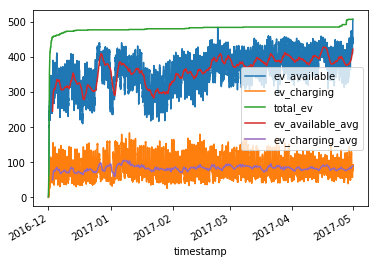

In [229]:
DAY = 12*24
df_charging['ev_available_avg'] = df_charging['ev_available'].rolling(window=2*DAY).mean()
df_charging['ev_charging_avg'] = df_charging['ev_charging'].rolling(window=2*DAY).mean()
df_charging.plot()

## Weekly Pattern of connected EVS

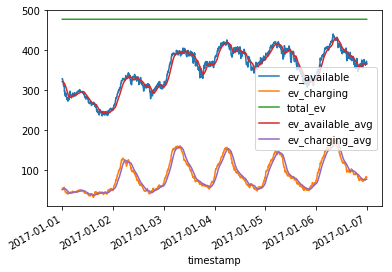

In [231]:
start = df_charging.index.searchsorted(datetime(2017, 1, 1))
end = df_charging.index.searchsorted(datetime(2017, 1, 7))

df_charging['ev_available_avg'] = df_charging['ev_available'].rolling(window=int(DAY/12)).mean()
df_charging['ev_charging_avg'] = df_charging['ev_charging'].rolling(window=int(DAY/12)).mean()
df_charging.iloc[start:end].plot();

## Daily Pattern of connected EVS

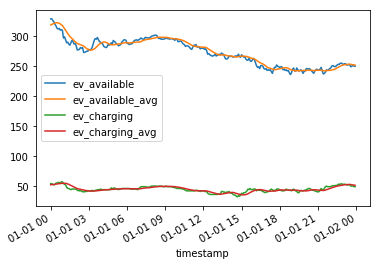

In [232]:
start = df_charging.index.searchsorted(datetime(2017, 1, 1))
end = df_charging.index.searchsorted(datetime(2017, 1, 2))

df_charging['ev_available_avg'] = df_charging['ev_available'].rolling(window=int(DAY/12/2)).mean()
df_charging['ev_charging_avg'] = df_charging['ev_charging'].rolling(window=int(DAY/12/2)).mean()
df_charging.iloc[start:end][['ev_available', 'ev_available_avg', 'ev_charging', 'ev_charging_avg']].plot();